# EDA

Before moving on to modeling, here's some valuable exploration to help better understand the data we're working with. The charts and manipulations help us build a general framework for our modeling approach moving forward

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

globe = pd.read_pickle('sample.pkl')
subset = pd.read_pickle('least_vars.pkl')

## Gloabl Sea Surface Temp

In [2]:
globe['timestamp'] = pd.to_datetime(globe[['year', 'month', 'day']])
newfoundland = globe[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

### Global vs Single Locaiton Trends

To illustrate the variance in sea surface temperature across the globe versus within a single set of coordinates, notice the thickness of the respective lines.

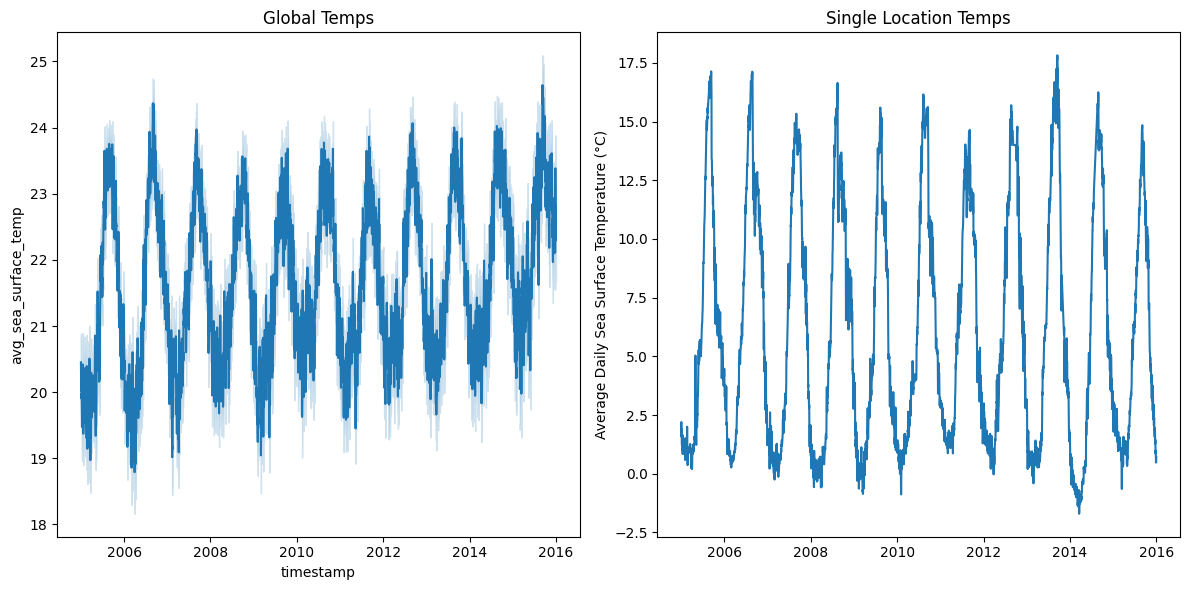

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=globe, x='timestamp', y='avg_sea_surface_temp', ax=ax[0])
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland, x='timestamp', y='avg_sea_surface_temp', ax=ax[1])
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

#### Potential Predictors of Sea Surface Temperature

We want to consider using additional variables outside of a sequence of the predictor, so lets look at a heatmap

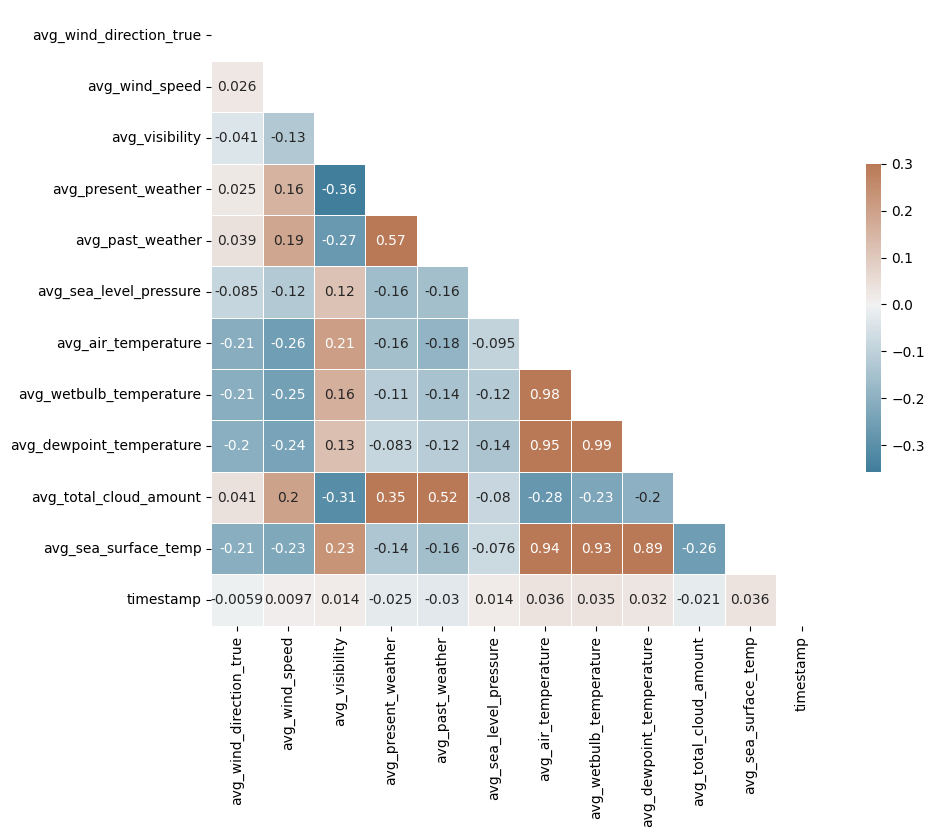

In [4]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = globe.drop(columns=['year', 'month', 'day', 'longitude', 'latitude']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)

plt.figure(figsize=(10, 8))  # Adjust the size of the figure as per your requirement
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']))
scaled = pd.DataFrame(scaler.transform(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp'])), columns=globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']).columns)
scaled['timestamp'] = globe['timestamp']

newfoundland_scaled = scaled[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

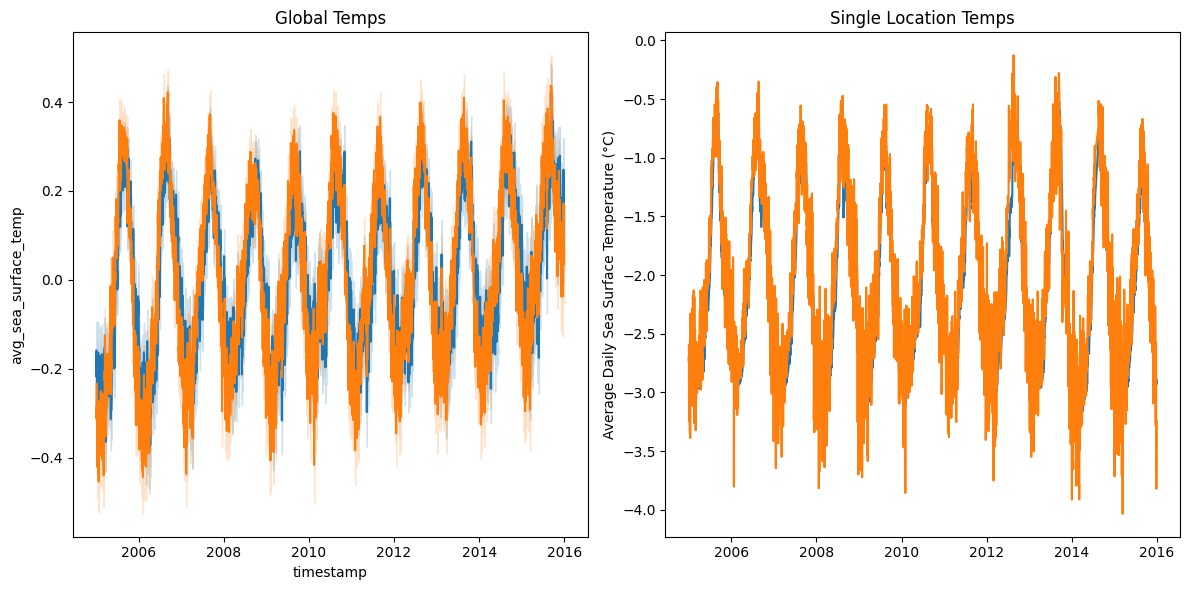

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[0])
sns.lineplot(data=scaled, x='timestamp', y='avg_air_temperature', ax=ax[0])
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[1])
sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_air_temperature', ax=ax[1])
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

You can see globally that the blue (sea temp) is preceeded by orange (air temp), this along with the heatmap would suggest it is a good covariate

### The Problem

Ultimately, it will be useful to model individual locations, rather than the global average. However, there are missing values throughout timestamps in certain locations

In [7]:
globe['Lat, Long'] = globe['latitude'].astype(str) + ', ' + globe['longitude'].astype(str)

In [8]:
example = globe[(globe['Lat, Long'] == '53.8, -3.5') | (globe['Lat, Long'] == '54.4, 11.1')]

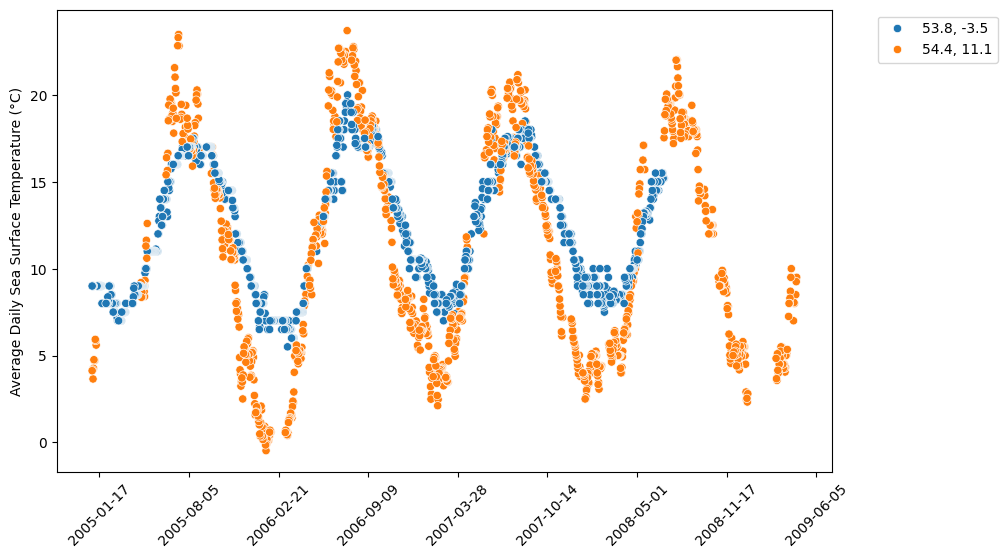

In [9]:
plt.figure(figsize=(10, 6))  # Adjust size if needed

sns.scatterplot(data=example[:-1], y='avg_sea_surface_temp', x='timestamp', hue='Lat, Long')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust number of xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.show()

## Manipulations

ICOADS unfortunately does not impute the null rows with a timestamp for data that wasn't recorded. We'll need to construct the timestamps ourselves and join back what data we have. The Ultimate goal is to interpolate the missing values (as these variables clearly follow a precise pattern). Additionally, we want to cut down the time window, as longer sequences will introduce vanishing gradient issues

In [10]:
subset['timestamp'] = pd.to_datetime(subset[['year', 'month', 'day']])
subset['lat, long'] = subset['latitude'].astype(str) + ', ' + subset['longitude'].astype(str)
subset.drop(columns=['avg_wetbulb_temperature'], inplace=True)

In [11]:
subset.head()

year  month  day  latitude  longitude  avg_air_temperature  \
0  2005      1   31      28.8      -15.6                 15.5   
1  2005      1   31      23.8      -81.0                 21.1   
2  2005      1   31     -19.6        4.6                 23.3   
3  2005      1   31     -11.7      174.9                 27.6   
4  2005      1   31      44.5     -149.0                 11.8   

   avg_sea_surface_temp  timestamp     lat, long  
0                  18.0 2005-01-31   28.8, -15.6  
1                  23.3 2005-01-31   23.8, -81.0  
2                  24.3 2005-01-31    -19.6, 4.6  
3                  30.0 2005-01-31  -11.7, 174.9  
4                  10.3 2005-01-31  44.5, -149.0

In [12]:
locations = subset[(subset['year'] == 2015) & subset['lat, long'].isin(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])]

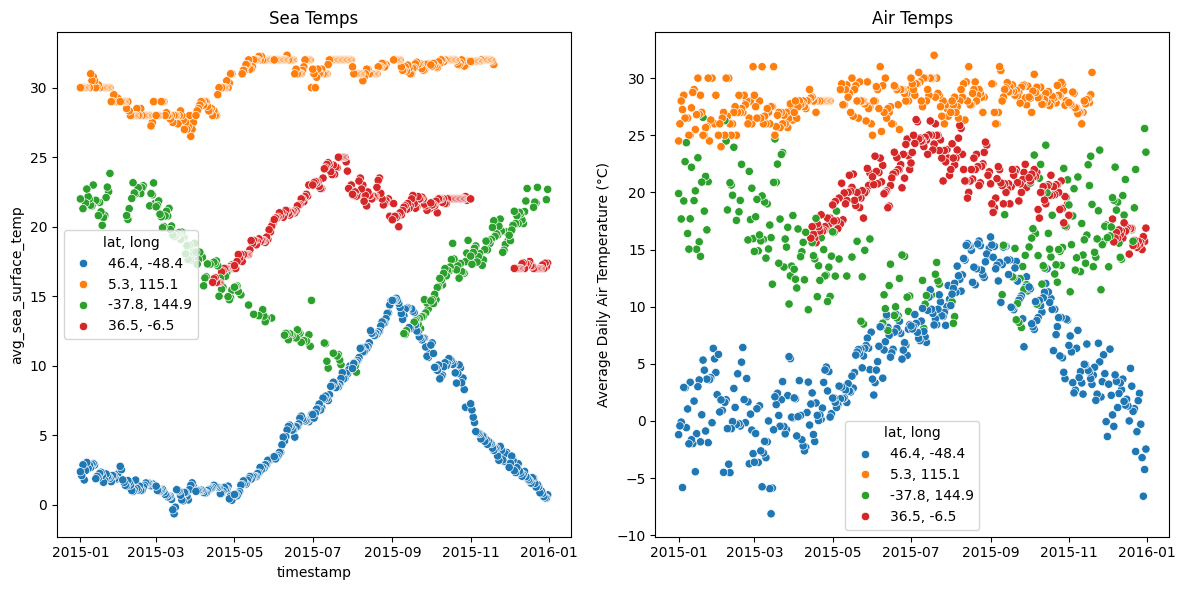

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=locations, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0])
ax[0].set_title('Sea Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.scatterplot(data=locations, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[1])
ax[1].set_title('Air Temps')

plt.ylabel('Average Daily Air Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [14]:
def build(locs):
    master = pd.DataFrame(columns=['timestamp', 'lat, long'])

    for loc in locs:
        loc_df = pd.DataFrame(columns=['timestamp', 'lat, long'])
        loc_df['timestamp'] = pd.date_range(start='1-1-2015', end='12-31-2015', freq='D')
        loc_df['lat, long'] = loc
        master = pd.concat([master, loc_df])

    return master

locs = build(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])
final_df = locs.merge(locations.drop(columns=['year', 'month', 'day', 'latitude', 'longitude']), on=['timestamp', 'lat, long'], how='outer')

In [15]:
final_df

timestamp    lat, long  avg_air_temperature  avg_sea_surface_temp
0    2015-01-01  46.4, -48.4            -1.200000              2.375000
1    2015-01-02  46.4, -48.4            -0.428571              2.100000
2    2015-01-03  46.4, -48.4            -0.100000              2.871429
3    2015-01-04  46.4, -48.4            -5.828571              1.785714
4    2015-01-05  46.4, -48.4             2.937500              2.462500
...         ...          ...                  ...                   ...
1455 2015-12-27   36.5, -6.5            15.625000             17.250000
1456 2015-12-28   36.5, -6.5            15.000000             17.000000
1457 2015-12-29   36.5, -6.5            16.125000             17.375000
1458 2015-12-30   36.5, -6.5            15.714286             17.142857
1459 2015-12-31   36.5, -6.5            16.875000             17.375000

[1460 rows x 4 columns]

In [16]:
loc1 = final_df[final_df['lat, long'] == '46.4, -48.4']     # already full
loc2 = final_df[final_df['lat, long'] == '5.3, 115.1']      # missing 59
loc3 = final_df[final_df['lat, long'] == '-37.8, 144.9']    # missing 134
loc4 = final_df[final_df['lat, long'] == '36.5, -6.5']      # missing 136 (and at beginning, need to inverse)

In [17]:
def interp(df):
    df['sea_interp'] = df['avg_sea_surface_temp'].interpolate(method='polynomial', order=1)
    df['air_interp'] = df['avg_air_temperature'].interpolate(method='polynomial', order=1)

    df['full_sea'] = df['sea_interp'].fillna(method='bfill').fillna(method='ffill')
    df['full_air'] = df['air_interp'].fillna(method='bfill').fillna(method='ffill')

    return df

In [18]:
locations = [loc1, loc2, loc3, loc4]

data = pd.DataFrame(columns=final_df.columns)
data['sea_interp'] = np.nan
data['air_interp'] = np.nan

for location in locations:
    location = interp(location)
    data = pd.concat([data, location])

<ipython-input-17-d26f6d7701fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sea_interp'] = df['avg_sea_surface_temp'].interpolate(method='polynomial', order=1)
<ipython-input-17-d26f6d7701fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['air_interp'] = df['avg_air_temperature'].interpolate(method='polynomial', order=1)
<ipython-input-17-d26f6d7701fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [19]:
data

timestamp    lat, long  avg_air_temperature  avg_sea_surface_temp  \
0    2015-01-01  46.4, -48.4            -1.200000              2.375000   
1    2015-01-02  46.4, -48.4            -0.428571              2.100000   
2    2015-01-03  46.4, -48.4            -0.100000              2.871429   
3    2015-01-04  46.4, -48.4            -5.828571              1.785714   
4    2015-01-05  46.4, -48.4             2.937500              2.462500   
...         ...          ...                  ...                   ...   
1455 2015-12-27   36.5, -6.5            15.625000             17.250000   
1456 2015-12-28   36.5, -6.5            15.000000             17.000000   
1457 2015-12-29   36.5, -6.5            16.125000             17.375000   
1458 2015-12-30   36.5, -6.5            15.714286             17.142857   
1459 2015-12-31   36.5, -6.5            16.875000             17.375000   

      sea_interp  air_interp   full_sea   full_air  
0       2.375000   -1.200000   2.375000  -1.200000  
1       2.100000   -0.428571   2.100000  -0.428571  
2       2.871429   -0.100000   2.871429  -0.100000  
3       1.785714   -5.828571   1.785714  -5.828571  
4       2.462500    2.937500   2.462500   2.937500  
...          ...         ...        ...        ...  
1455   17.250000   15.625000  17.250000  15.625000  
1456   17.000000   15.000000  17.000000  15.000000  
1457   17.375000   16.125000  17.375000  16.125000  
1458   17.142857   15.714286  17.142857  15.714286  
1459   17.375000   16.875000  17.375000  16.875000  

[1460 rows x 8 columns]

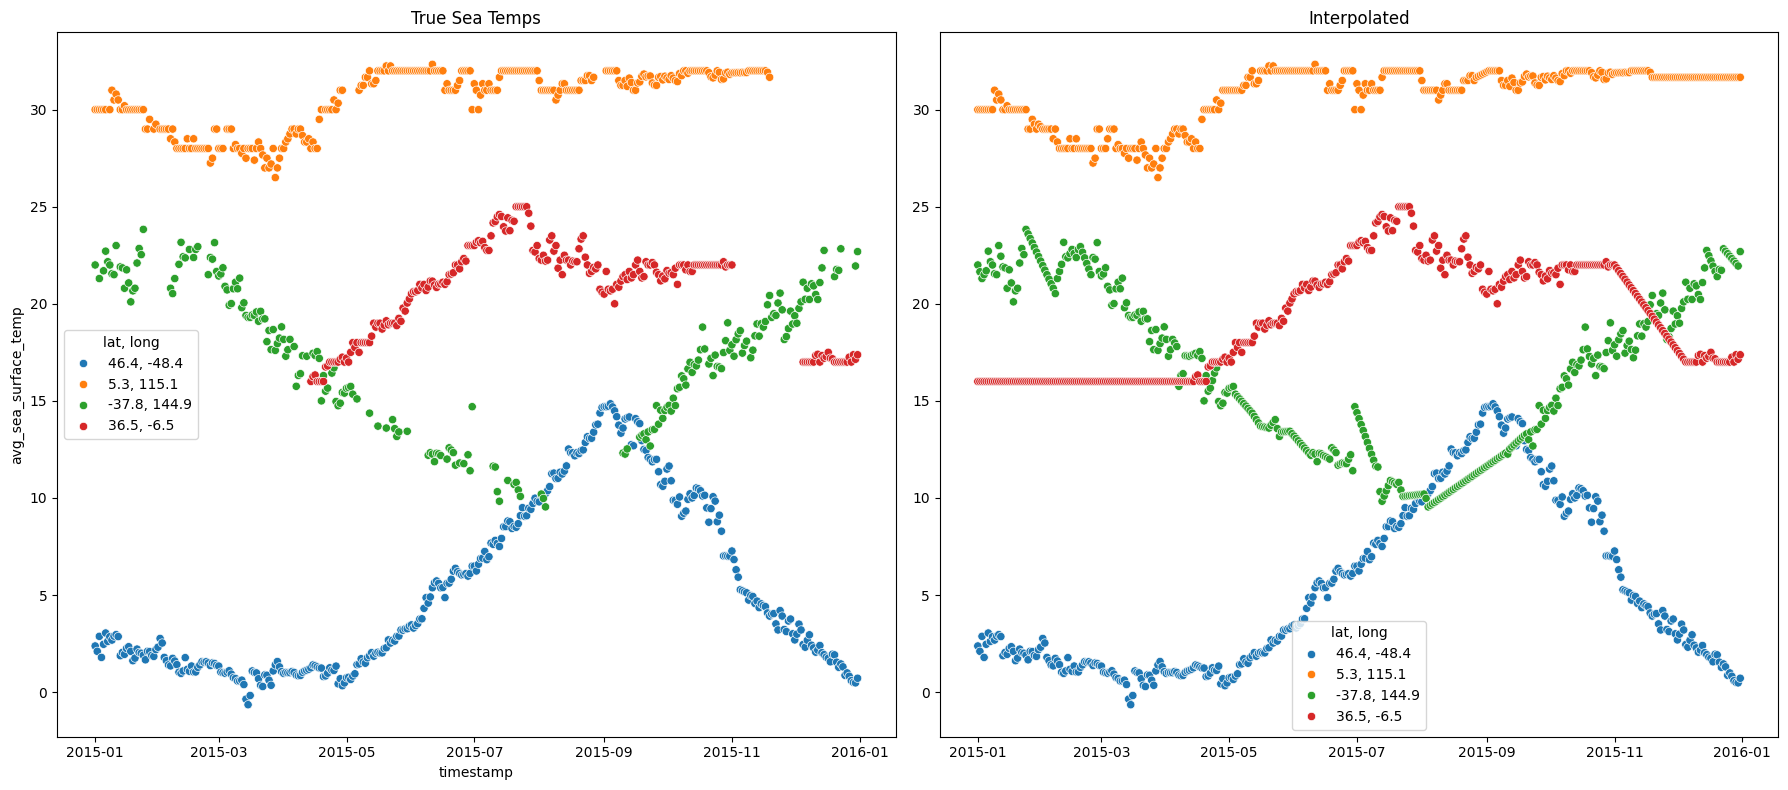

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0])
ax[0].set_title('True Sea Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_sea', hue='lat, long', ax=ax[1])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

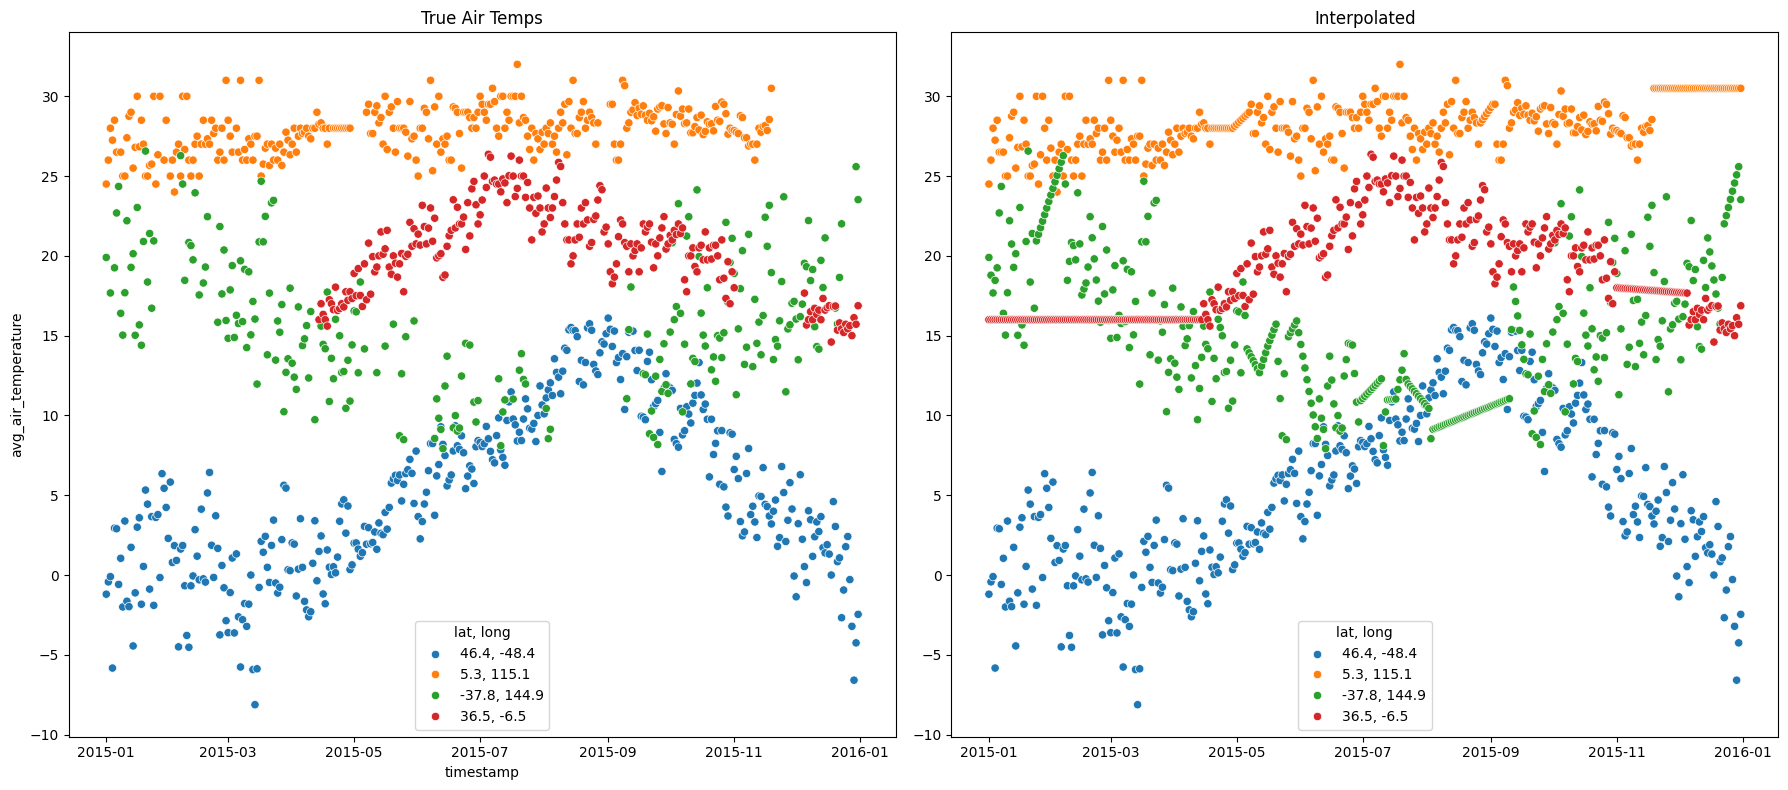

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[0])
ax[0].set_title('True Air Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_air', hue='lat, long', ax=ax[1])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

# RNN
---

In [39]:
data

timestamp    lat, long  avg_air_temperature  avg_sea_surface_temp  \
0    2015-01-01  46.4, -48.4            -1.200000              2.375000   
1    2015-01-02  46.4, -48.4            -0.428571              2.100000   
2    2015-01-03  46.4, -48.4            -0.100000              2.871429   
3    2015-01-04  46.4, -48.4            -5.828571              1.785714   
4    2015-01-05  46.4, -48.4             2.937500              2.462500   
...         ...          ...                  ...                   ...   
1455 2015-12-27   36.5, -6.5            15.625000             17.250000   
1456 2015-12-28   36.5, -6.5            15.000000             17.000000   
1457 2015-12-29   36.5, -6.5            16.125000             17.375000   
1458 2015-12-30   36.5, -6.5            15.714286             17.142857   
1459 2015-12-31   36.5, -6.5            16.875000             17.375000   

      sea_interp  air_interp   full_sea   full_air  
0       2.375000   -1.200000   2.375000  -1.200000  
1       2.100000   -0.428571   2.100000  -0.428571  
2       2.871429   -0.100000   2.871429  -0.100000  
3       1.785714   -5.828571   1.785714  -5.828571  
4       2.462500    2.937500   2.462500   2.937500  
...          ...         ...        ...        ...  
1455   17.250000   15.625000  17.250000  15.625000  
1456   17.000000   15.000000  17.000000  15.000000  
1457   17.375000   16.125000  17.375000  16.125000  
1458   17.142857   15.714286  17.142857  15.714286  
1459   17.375000   16.875000  17.375000  16.875000  

[1460 rows x 8 columns]

In [118]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

X = data[['avg_sea_surface_temp']]

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X)

In [119]:
scaled_data = np.nan_to_num(scaled_data, nan = 0)

In [120]:
pd.DataFrame(scaled_data).isna().sum()

0    0
dtype: int64

In [121]:
# Creating sequences
sequence_length = 7

def create_sequences(data, sequence_length):

  total_sequence=[]
  prices = []

  for day in range(0, (len(data) - sequence_length)):
    start_index = day
    end_index = sequence_length + day
    day_sequence = data[start_index:end_index]
    day_price = data[end_index]

    total_sequence.append(day_sequence)
    prices.append(day_price)
  return np.array(total_sequence), np.array(prices)

sequences = create_sequences(scaled_data, sequence_length)
X = sequences[0]
y = sequences[1]

In [122]:
import torch

# Splitting the data
split_ratio = 0.8
train_size = int(len(data) * split_ratio)

# Split the data into training and testing sets
train_size = int(X.shape[0]* split_ratio)
X_train = torch.tensor(X[:train_size]).float()
y_train = torch.tensor(y[:train_size]).float()
X_test = torch.tensor(X[train_size:]).float()
y_test = torch.tensor(y[train_size:]).float()

In [123]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1162, 7, 1]),
 torch.Size([291, 7, 1]),
 torch.Size([1162, 1]),
 torch.Size([291, 1]))

In [127]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 64  # Number of hidden units in the RNN
num_layers = 4  # Number of RNN layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(model)

RNN(
  (rnn): RNN(1, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [128]:
import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()  # Mean Absolute Error (MAE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy (MAE)
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy (MSE): {train_accuracy:.4f}, Test Accuracy (MSE): {test_accuracy:.4f}')

Epoch [1/10], Training Accuracy (MSE): 0.3482, Test Accuracy (MSE): 0.2649
Epoch [2/10], Training Accuracy (MSE): 0.3391, Test Accuracy (MSE): 0.1957
Epoch [3/10], Training Accuracy (MSE): 0.3533, Test Accuracy (MSE): 0.1970
Epoch [4/10], Training Accuracy (MSE): 0.3430, Test Accuracy (MSE): 0.2265
Epoch [5/10], Training Accuracy (MSE): 0.3241, Test Accuracy (MSE): 0.2591
Epoch [6/10], Training Accuracy (MSE): 0.3096, Test Accuracy (MSE): 0.2786
Epoch [7/10], Training Accuracy (MSE): 0.2993, Test Accuracy (MSE): 0.2741
Epoch [8/10], Training Accuracy (MSE): 0.2860, Test Accuracy (MSE): 0.2429
Epoch [9/10], Training Accuracy (MSE): 0.2654, Test Accuracy (MSE): 0.1860
Epoch [10/10], Training Accuracy (MSE): 0.2376, Test Accuracy (MSE): 0.1094


## RNN Multiple Variables


In [170]:
data.head(2)

timestamp    lat, long  avg_air_temperature  avg_sea_surface_temp  \
0 2015-01-01  46.4, -48.4            -1.200000                 2.375   
1 2015-01-02  46.4, -48.4            -0.428571                 2.100   

   sea_interp  air_interp  full_sea  full_air  
0       2.375   -1.200000     2.375 -1.200000  
1       2.100   -0.428571     2.100 -0.428571

In [165]:
# # Reshape data into groups of 358 samples
# num_groups = 4
# group_size = len(scaled_data) // num_groups

# X_grouped = []
# y_grouped = []

# for i in range(num_groups):
#     start_index = i * group_size
#     end_index = start_index + group_size
#     group_sequences, group_prices = create_sequences(scaled_data[start_index:end_index], sequence_length)
#     X_grouped.append(group_sequences)
#     y_grouped.append(group_prices)

# # Stack the groups along a new dimension
# X = np.stack(X_grouped, axis=0)
# y = np.stack(y_grouped, axis=0)

# # Print the shapes of X and y
# print("Shape of X:", X.shape)
# print("Shape of y:", y.shape)

Shape of X: (4, 358, 7, 6)
Shape of y: (4, 358, 6)


In [171]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

X = data.drop(columns = ['timestamp', 'lat, long'])

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(X)

In [172]:
scaled_data = np.nan_to_num(scaled_data, nan = 0)

In [173]:
pd.DataFrame(scaled_data).isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [174]:
# Creating sequences
sequence_length = 7

def create_sequences(data, sequence_length):

  total_sequence=[]
  prices = []

  for day in range(0, (len(data) - sequence_length)):
    start_index = day
    end_index = sequence_length + day
    day_sequence = data[start_index:end_index]
    day_price = data[end_index]

    total_sequence.append(day_sequence)
    prices.append(day_price)
  return np.array(total_sequence), np.array(prices)

sequences = create_sequences(scaled_data, sequence_length)
X = sequences[0]
y = sequences[1]

X.shape, y.shape

((1453, 7, 6), (1453, 6))

In [175]:
import torch

# Splitting the data
split_ratio = 0.8
train_size = int(len(data) * split_ratio)

# Split the data into training and testing sets
train_size = int(X.shape[0]* split_ratio)
X_train = torch.tensor(X[:train_size]).float()
y_train = torch.tensor(y[:train_size]).float()
X_test = torch.tensor(X[train_size:]).float()
y_test = torch.tensor(y[train_size:]).float()

In [176]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1162, 7, 6]),
 torch.Size([291, 7, 6]),
 torch.Size([1162, 6]),
 torch.Size([291, 6]))

In [177]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 6  # Number of features in input data (e.g., time series)
hidden_size = 64  # Number of hidden units in the RNN
num_layers = 4  # Number of RNN layers
output_size = 6  # Number of features in output data (e.g., regression target)

# Instantiate the model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(model)

RNN(
  (rnn): RNN(6, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [178]:
import torch.optim as optim

# Define the loss function
criterion = nn.MSELoss()  # Mean Absolute Error (MAE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy (MAE)
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy (MSE): {train_accuracy:.4f}, Test Accuracy (MSE): {test_accuracy:.4f}')

Epoch [1/10], Training Accuracy (MSE): 0.5010, Test Accuracy (MSE): 0.5189
Epoch [2/10], Training Accuracy (MSE): 0.4370, Test Accuracy (MSE): 0.4446
Epoch [3/10], Training Accuracy (MSE): 0.3775, Test Accuracy (MSE): 0.3624
Epoch [4/10], Training Accuracy (MSE): 0.3252, Test Accuracy (MSE): 0.2753
Epoch [5/10], Training Accuracy (MSE): 0.2861, Test Accuracy (MSE): 0.1944
Epoch [6/10], Training Accuracy (MSE): 0.2718, Test Accuracy (MSE): 0.1514
Epoch [7/10], Training Accuracy (MSE): 0.2756, Test Accuracy (MSE): 0.1384
Epoch [8/10], Training Accuracy (MSE): 0.2857, Test Accuracy (MSE): 0.1450
Epoch [9/10], Training Accuracy (MSE): 0.2923, Test Accuracy (MSE): 0.1541
Epoch [10/10], Training Accuracy (MSE): 0.2920, Test Accuracy (MSE): 0.1579


# LSTM

---

In [152]:
import torch.optim as optim
import torch.nn as nn

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 6  # Number of features in input data (e.g., time series)
hidden_size = 64  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 6  # Number of features in output data (e.g., regression target)

# Instantiate the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(model)

LSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [153]:
# Define the loss function
criterion = nn.MSELoss()  # Mean Absolute Error (MAE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {train_accuracy:.4f}, Test MSE: {test_accuracy:.4f}')

Epoch [1/10], Training MSE: 0.5081, Test MSE: 0.5865
Epoch [2/10], Training MSE: 0.4970, Test MSE: 0.5745
Epoch [3/10], Training MSE: 0.4860, Test MSE: 0.5621
Epoch [4/10], Training MSE: 0.4748, Test MSE: 0.5491
Epoch [5/10], Training MSE: 0.4631, Test MSE: 0.5351
Epoch [6/10], Training MSE: 0.4506, Test MSE: 0.5198
Epoch [7/10], Training MSE: 0.4372, Test MSE: 0.5028
Epoch [8/10], Training MSE: 0.4227, Test MSE: 0.4835
Epoch [9/10], Training MSE: 0.4070, Test MSE: 0.4614
Epoch [10/10], Training MSE: 0.3894, Test MSE: 0.4356


In [150]:
import torch.optim as optim
import torch.nn as nn

class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout=0.0):
        super(ComplexLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Decode the hidden state of the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 6  # Number of features in input data
hidden_size = 64  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 6  # Number of features in output data

# Instantiate the model
model = ComplexLSTM(input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout=0.2)

# Print model architecture
print(model)

ComplexLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [151]:
# Define the loss function
criterion = nn.MSELoss()  # Mean Absolute Error (MAE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training MSE: {train_accuracy:.4f}, Test MSE: {test_accuracy:.4f}')

Epoch [1/10], Training MSE: 0.9280, Test MSE: 0.6829
Epoch [2/10], Training MSE: 0.6106, Test MSE: 0.4043
Epoch [3/10], Training MSE: 0.3767, Test MSE: 0.1976
Epoch [4/10], Training MSE: 0.2527, Test MSE: 0.1776
Epoch [5/10], Training MSE: 0.2779, Test MSE: 0.2512
Epoch [6/10], Training MSE: 0.3398, Test MSE: 0.3082
Epoch [7/10], Training MSE: 0.3777, Test MSE: 0.3232
Epoch [8/10], Training MSE: 0.3850, Test MSE: 0.3092
Epoch [9/10], Training MSE: 0.3697, Test MSE: 0.2910
Epoch [10/10], Training MSE: 0.3397, Test MSE: 0.2620
